# Evaluation mountain car agents

In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src.tabular.discrete_agent import DiscreteAgent
from src.env.mountain_car import DiscreteMountainCar
from src.visualization.mountain_car import MountaincarVis

/Users/hfml/opt/miniconda3/envs/irl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def load_true_agent(env, gamma=0.99, alpha=10., horizon=0):
    transition = torch.from_numpy(env.transition_matrix).to(torch.float32)
    reward = torch.from_numpy(env.reward).to(torch.float32)
    log_transition = torch.log(transition + 1e-6)
    log_target = reward

    agent = DiscreteAgent(env.state_dim, env.act_dim, gamma, alpha, horizon)
    agent.log_transition.data = log_transition
    agent.log_target.data = log_target
    agent.plan()
    return agent

def load_trained_agent(env, path):
    # load args
    with open(os.path.join(path, "args.json"), "rb") as f:
        arglist = json.load(f)

    # load state dict
    state_dict = torch.load(os.path.join(path, "model.pt"))
    agent_state_dict = {
        k.replace("agent.", ""): v for (k, v) in state_dict["model_state_dict"].items() if "agent." in k
    }
    
    state_dim = env.state_dim
    act_dim = env.act_dim
    gamma = arglist["gamma"]
    alpha = arglist["alpha"]
    horizon = arglist["horizon"]
    agent = DiscreteAgent(state_dim, act_dim, gamma, alpha, horizon)

    agent.load_state_dict(agent_state_dict)
    
    # handle pil agents
    bonus =None
    if "state_marginal" in state_dict["model_state_dict"]:
        agent.pess_penalty = arglist["pess_penalty"]
        agent.state_marginal = state_dict["model_state_dict"]["state_marginal"]
        agent.bonus = agent.pess_penalty * torch.log(agent.state_marginal + 1e-6)
        with torch.no_grad():
            bonus = agent.pess_penalty * torch.log(agent.state_marginal + 1e-6)

    agent.plan(bonus)
    return agent

In [9]:
env = DiscreteMountainCar()
vis = MountaincarVis(env)

In [10]:
# load ground truth agent
true_agent = load_true_agent(env)

In [30]:
# load btom agent
exp_path = "../exp/mountain_car/btom"
# btom_agent = load_trained_agent(env, os.path.join(exp_path, "03-18-2023 12-11-34"))
btom_agent = load_trained_agent(env, os.path.join(exp_path, "03-18-2023 14-47-59"))

In [34]:
# load irl agent
exp_path = "../exp/mountain_car/irl"
# irl_agent = load_trained_agent(env, os.path.join(exp_path, "03-18-2023 14-21-09"))
irl_agent = load_trained_agent(env, os.path.join(exp_path, "03-18-2023 16-43-44"))

In [37]:
# load pil agent
exp_path = "../exp/mountain_car/pil"
# pil_agent = load_trained_agent(env, os.path.join(exp_path, "03-18-2023 14-32-11"))
pil_agent = load_trained_agent(env, os.path.join(exp_path, "03-18-2023 17-16-54"))

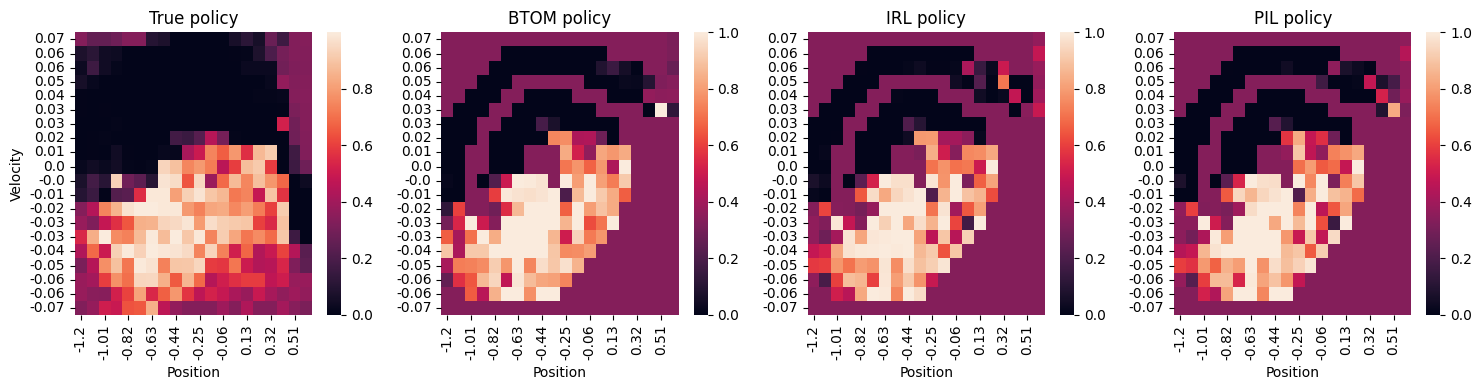

In [38]:
# plot policy
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
vis.plot_value_map(true_agent.pi[:, 0].data, ax[0])
vis.plot_value_map(btom_agent.pi[:, 0].data, ax[1])
vis.plot_value_map(irl_agent.pi[:, 0].data, ax[2])
vis.plot_value_map(pil_agent.pi[:, 0].data, ax[3])

ax[0].set_ylabel("Velocity")
ax[0].set_xlabel("Position")
ax[1].set_xlabel("Position")
ax[2].set_xlabel("Position")
ax[3].set_xlabel("Position")

ax[0].set_title("True policy")
ax[1].set_title("BTOM policy")
ax[2].set_title("IRL policy")
ax[3].set_title("PIL policy")
plt.tight_layout()
plt.show()

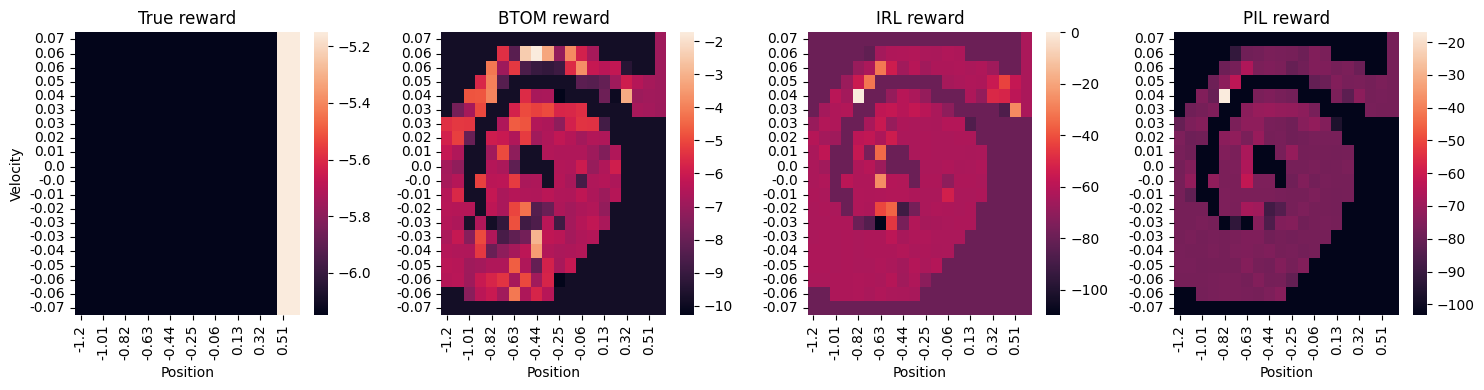

In [40]:
# plot reward
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
vis.plot_value_map(true_agent.reward().data, ax[0])
vis.plot_value_map(btom_agent.reward().data, ax[1])
vis.plot_value_map(irl_agent.reward().data, ax[2])
vis.plot_value_map(
    pil_agent.reward().data + pil_agent.bonus,
    ax[3]
)

ax[0].set_ylabel("Velocity")
ax[0].set_xlabel("Position")
ax[1].set_xlabel("Position")
ax[2].set_xlabel("Position")
ax[3].set_xlabel("Position")

ax[0].set_title("True reward")
ax[1].set_title("BTOM reward")
ax[2].set_title("IRL reward")
ax[3].set_title("PIL reward")
plt.tight_layout()
plt.show()

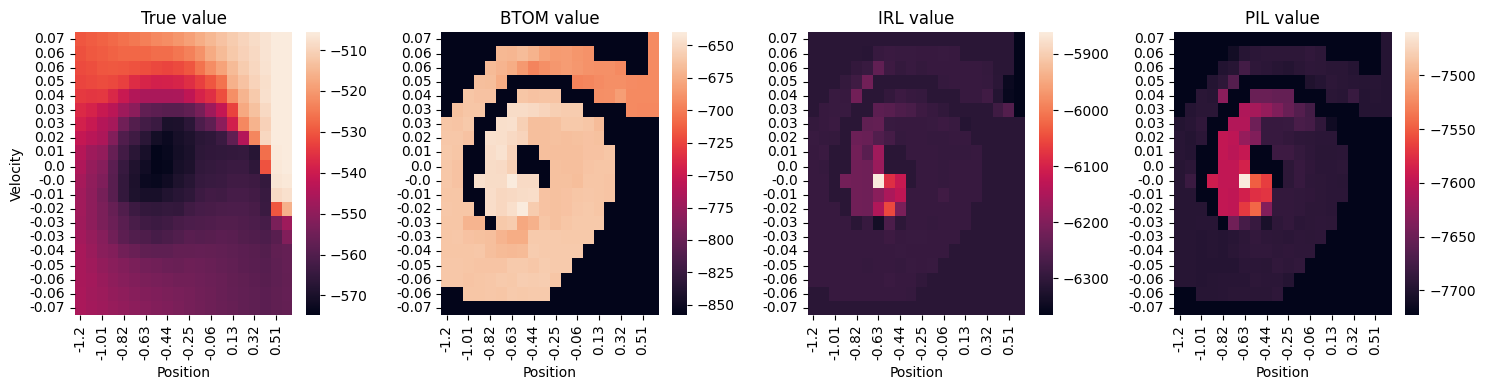

In [41]:
# plot value
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
vis.plot_value_map(true_agent.v.data, ax[0])
vis.plot_value_map(btom_agent.v.data, ax[1])
vis.plot_value_map(irl_agent.v.data, ax[2])
vis.plot_value_map(pil_agent.v.data, ax[3])

ax[0].set_ylabel("Velocity")
ax[0].set_xlabel("Position")
ax[1].set_xlabel("Position")
ax[2].set_xlabel("Position")
ax[3].set_xlabel("Position")

ax[0].set_title("True value")
ax[1].set_title("BTOM value")
ax[2].set_title("IRL value")
ax[3].set_title("PIL value")
plt.tight_layout()
plt.show()

## Evaluate transitions

In [58]:
def plot_transition_row(transition, ax, model_name, a_labels, vmin=0., vmax=1., cmap=None):
    for i in range(len(transition)):
        sns.heatmap(
            transition[i], vmin=vmin, vmax=vmax, annot=False, cbar=False, cmap=cmap, ax=ax[i]
        )
        ax[i].set_title(f"{model_name}, a={a_labels[i]}")

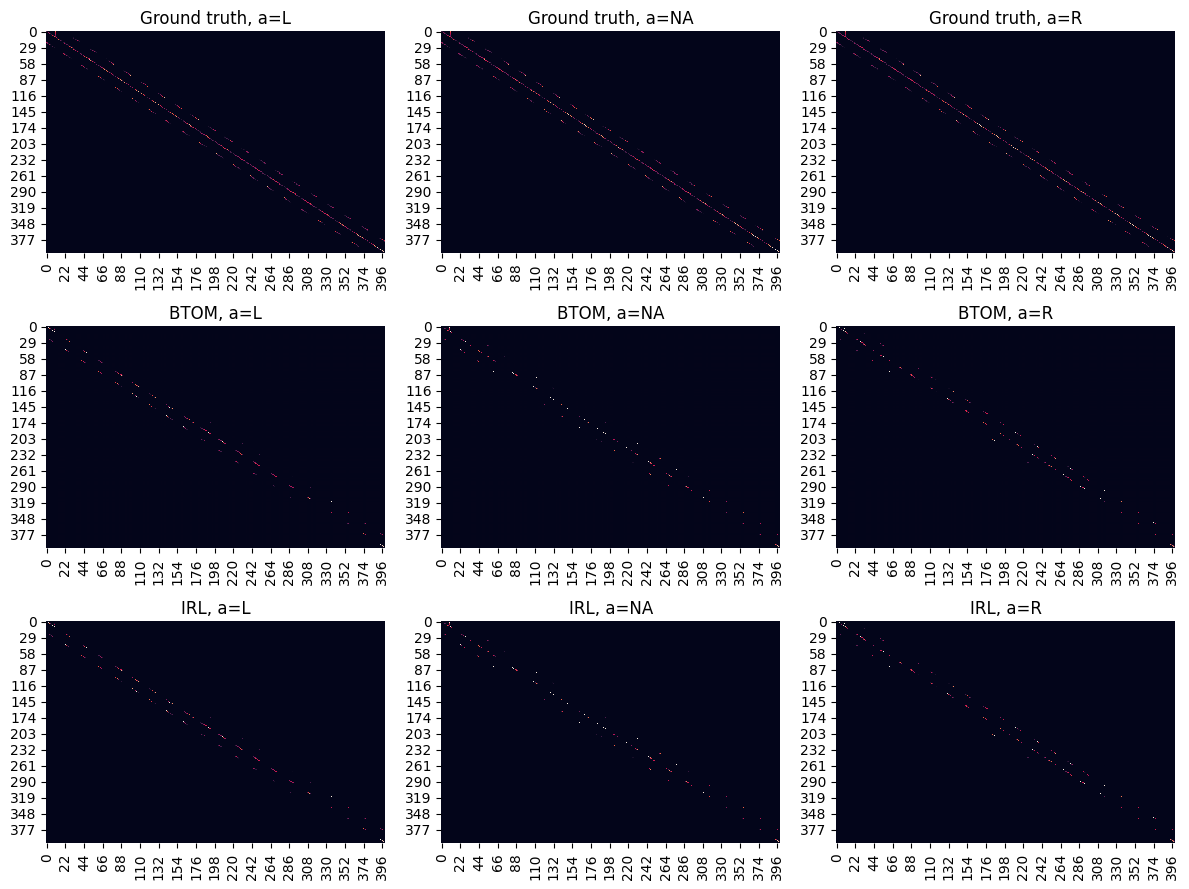

In [59]:
a_labels = ["L", "NA", "R"]
fig, ax = plt.subplots(3, 3, figsize=(12, 9))
plot_transition_row(true_agent.transition().data, ax[0], "Ground truth", a_labels)
plot_transition_row(btom_agent.transition().data, ax[1], "BTOM", a_labels)
plot_transition_row(irl_agent.transition().data, ax[2], "IRL", a_labels)
plt.tight_layout()
plt.show()